# Parte 5
Vado a sfruttare il csv pulito che ho elaborato negli step precedenti. A partire da questo vogliamo addestrare un modello Word2Vec

In [2]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/BritishGB_cleaned_1000.csv")

In [ ]:
df.head()

Utilizzeremo la libreria **gensim** per il modello Word2Vec

[GENSIM-Word2Vec
](https://radimrehurek.com/gensim/models/word2vec.html)



```
classgensim.models.word2vec.Word2Vec(
    sentences=None, corpus_file=None, vector_size=100, alpha=0.025, window=5, min_count=5, 
    max_vocab_size=None, sample=0.001, seed=1, workers=3, min_alpha=0.0001, 
    sg=0, hs=0, negative=5, ns_exponent=0.75, cbow_mean=1, hashfxn=<built-in function hash>, 
    epochs=5, null_word=0, trim_rule=None, sorted_vocab=1, batch_words=10000, 
    compute_loss=False, callbacks=(), comment=None, max_final_vocab=None, shrink_windows=True)

```

Vediamo quali sono i parametri (la firma) per utilizzare questo algoritmo: 
- **sentences**: sono le frasi e vedremo come formattarle
- **vector_size**: quanto devono essere grandi i vettori che vengono generati
- **window**: la finestra considerata nell'addestramento per tener conto del contesto di ogni parola
- **min_count**: fa si che vengano ignorate le parole con frequenza inferiore ad una soglia specificata
- **workers**: il numero di thread che si vogliono usare per l'addestramento. 
- **sg**: consente di definire l'algoritmo di addestramento da usare (1 per skip-gram e 0 per il CBOW)
- **max_vocab_size**: specifico la dimensione massima del vocabolario (utile quando sono troppo grandi)
- epochs: numero di volte che il dataset viene processato dal modello
- **batch_words**: quando il dataset è troppo grande e non entra nella RAM permette di fornire dati un po alla volta
- **compute_loss**: funzione che il modello minimizza durante l'apprendimento. Lui la calcola e la mette in una variabile


il resto sono dettagli che non abbiamo discusso e li trascureremo

In [4]:
df["cleaned_text"]

0       bon week-end de gp de grande bretagne 🇬🇧 forza...
1       motivo ferrari fallito fernando alonso motivo ...
2       vorrei sommessamente ricordare ignazio ruota o...
3       seb corre andare interviste mick f1tv 😊 britishgp
4       commento marc_gene gran premio gran bretagna e...
                              ...                        
1105    binotto permette pure puntare dito verso charl...
1106    oggi visto cosa manca ancora ferrari diventare...
1107    jules bianchi salvato vita due ragazzi oggi du...
1108    poi spiegate perchè ferrari sentita fare doppi...
1109    qui po gente capito paio cose 1 qui sai esplic...
Name: cleaned_text, Length: 1110, dtype: object

Usiamo questa colonna pulita per fare l'addestramento in quanto avere solo parole di senso compiuto aiuta l'algoritmo

Puo essere utile invece andare a considerare anche i BIGRAMMI ovvero le coppie di parole:

In [5]:
# considero le frasi come liste di liste 
sent = [row.split() for row in df["cleaned_text"]]
sent[0]

['bon',
 'week-end',
 'de',
 'gp',
 'de',
 'grande',
 'bretagne',
 '🇬🇧',
 'forza',
 'ferrari',
 '🇮🇹🏁',
 'f1',
 'ferrari',
 'britishgp',
 'carlos55',
 '🇪🇸',
 'charles16',
 '🇲🇨',
 'jjlemans37…']

Usando la libreria GENSIM istanzio un oggetto Phrases che conterrà tutte le frasi che vogliamo considerare. 

In [6]:
from gensim.models.phrases import Phrases, Phraser

# considero solo frasi con lunghezza almeno pari a 10
phrases = Phrases(sent, min_count=10)

# considero i bigrammi utilizzando le frasi appena create
bigram = Phraser(phrases)


sentences = bigram[sent]

Capiamo innanzitutto Colab quanti core mi mette a disposizione:

In [7]:
import multiprocessing
cores = multiprocessing.cpu_count()
cores

2

mi mette a disposizione 2 cpu

### Instanziamo il modello Word2Vec

In [8]:
from numpy import negative
# importo il modello che voglio addestrare: 
from gensim.models import Word2Vec
model = Word2Vec(
    window=10, 
    min_count=5, 
    size=100, 
    sample=6e-5, 
    alpha=0.03, 
    min_alpha=0.007,
    negative=10, 
    workers=cores
)

Andiamo a creare un vocabolario:

In [9]:
model.build_vocab(sentences) #diamo le frasi in pasto al modello

In [10]:
model.corpus_count #restituisce la dimensione del corpus fornito al modello

1110

### Possiamo effettuare l'addestramento

In [11]:
# per poter vedere le operazioni che vengono eseguite importiamo la mibreria logging
import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.INFO)

avviamo l'addestramento passando: 
- frasi di addestramento 
- numero totale di esempi 
- numero di epoche

In [12]:
model.train(sentences, total_examples=model.corpus_count, epochs=100)

2022-07-10 15:51:33,219 : INFO : training model with 2 workers on 597 vocabulary and 100 features, using sg=0 hs=0 sample=6e-05 negative=10 window=10
2022-07-10 15:51:33,276 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-07-10 15:51:33,281 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-07-10 15:51:33,284 : INFO : EPOCH - 1 : training on 12853 raw words (1857 effective words) took 0.1s, 32792 effective words/s
2022-07-10 15:51:33,335 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-07-10 15:51:33,337 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-07-10 15:51:33,340 : INFO : EPOCH - 2 : training on 12853 raw words (1911 effective words) took 0.0s, 41601 effective words/s
2022-07-10 15:51:33,394 : INFO : worker thread finished; awaiting finish of 1 more threads
2022-07-10 15:51:33,395 : INFO : worker thread finished; awaiting finish of 0 more threads
2022-07-10 15:51:33,399 : INFO : EPOCH - 3

(189977, 1285300)

Terminato l'addestramento abbiamo a disposizione un modello in grado di determinare gli embedding associati a ciascuna parola

In [13]:
model.wv.similar_by_word("f1") #prende in input una parola e restituisce tutte le parole piu simili

2022-07-10 15:51:39,201 : INFO : precomputing L2-norms of word weight vectors


[('prima', 0.9868537187576294),
 ('f2', 0.9843828678131104),
 ('podcast', 0.9839251041412354),
 ('primo', 0.9837083220481873),
 ('vittoria', 0.983705997467041),
 ('marco', 0.9833459258079529),
 ('commento', 0.9831298589706421),
 ('📄', 0.9827016592025757),
 ('pista', 0.9818433523178101),
 ('binotto', 0.981723427772522)]

Il fatto che ci siano parole che sembrano non aver alcun legame con la parola pace in realtà sono legate per qualche fatto avvenuto in quei giorni. 

In [14]:
model.wv.similar_by_word("ferrari")

[("''", 0.9799423217773438),
 ('``', 0.9764479994773865),
 ('f1', 0.9653254747390747),
 ('horner', 0.9598473310470581),
 ('vergognatevi', 0.9577202200889587),
 ('mattia', 0.9565735459327698),
 ('binottoout', 0.9556677341461182),
 ('stato', 0.9554978609085083),
 ('casa', 0.9553418159484863),
 ('considerazioni', 0.9552841186523438)]

# Parte 6: T-SNE 
### How to visualize embeddings
A partire dagli embedding che abbiamo a disposizione per ogni parola, vogliamo riuscire a rappresentare su uno spazio bidimensionale tutte le frasi che abbiamo a disposizione, per capire come sono disposte in questo spazio.

Per fare in modo che possano essere resi human-understandable occorre ridurre la dimensionalità (2/3 dimensioni). Due fra le tecniche disponibili sono:
- PCS: Principal component Analysis
- T-SNE

Abbiamo a disposizione Embedding di parole e non di frasi quindi dobbiamo prima ricavare gli embedding delle frasi. Si possono ricavare in diversi modi. 

Un modo semplice ma funzionale è quello di calcolare la media degli embedding di ciascuna frase ovvero: 

- supponiamo di partire da una lista di embeddings vuota
- iteriamo su tutta la mia lista di frasi
- per ciascuna frase definisco un sentece_embedding che inizializzo come vettore nullo di 100 elementi
- 

In [15]:
import numpy as np
embeddings = []
for sentence in sentences: 
    sentence_embedding = np.zeros((100,)) # inizializzo il vettore di 100 elementi con tutti zeri
    for word in sentence: #per ogni parola considero l'embedding e lo aggiungo al l'embedding di frase
        try:
            sentence_embedding += model.wv[word]
        except:
            pass #salto il ciclo di iterazione se incontro una parola che non è nel vocabolario creato precedentemente
    
    #calcolo la media dividendo per il numero di parole nella frase
    sentence_embedding = sentence_embedding / len(sentence)
    embeddings.append(sentence_embedding)


Utilizziamo ora T-SNE per effettuare la rappresentazione degli embedding di frasi. Importiamo il TSNE da sklearn. 
Devo passare alla classe TSNE il numero di componenti ed una serie di parametri che hanno impatto sulle performance e quindi vanno opportunamente settate. Evitiamo di farlo e vediamo come va.

In [16]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

#applico l'algoritmo istanziato sugli esempi embedding e metto il risultato in una var
tsne_results = tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Rappresento graficamente il risultato con un plot

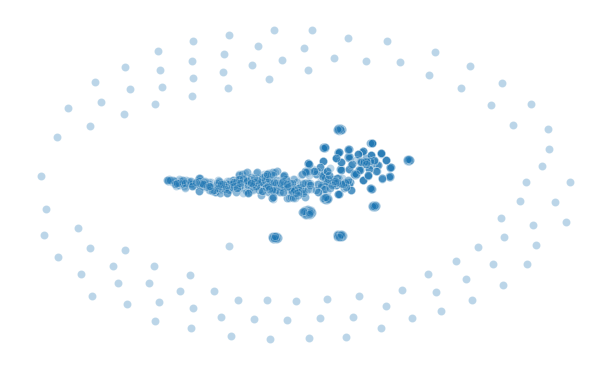

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

df_subset = pd.DataFrame()
df_subset["tsne-one"] = tsne_results[:, 0]
df_subset["tsne-two"] = tsne_results[:, 1]

fig = plt.figure(figsize = (5,3), dpi=150)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

sc = sns.scatterplot(
    x="tsne-one", y="tsne-two",
    data=df_subset,
    legend=None,
    alpha=0.3,
    s=15
)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/.jpg') 

come vediamo dalla figura i cerchi di colore piu intenso sono punti sovrapposti. Questo è dovuto ai retweet e quindi una frase che è identica ad un'altra. 

# Parte 7: Clustering semantically similar tweets
Risusciamo a trovare dei raggruppamenti di tweet dal punto di vista semantico simili fra di loro?
Per farlo utilizziamo gli algoritmi di clustering e utilizziamo il word cloud per visualizzare i cluster. 

cerchiamo di ricavare cosi il topic principale dei post afferenti a ciascun cluster. 

In [20]:
from sklearn.cluster import KMeans

#definiamo il numero di cluster: 
NUM_CLUSTERS = 5
#instanziamo l'oggetto della classe KMeans
kclusterer = KMeans(NUM_CLUSTERS) # specifico il numero di cluster

#assegno i cluster alle varie frasi 
assigned_clusters = kclusterer.fit(embeddings) #passo i punti/frasi su cui voglio applicare il clustering

In [21]:
#ottengo i centroidi dei vari cluster 
centroids = kclusterer.cluster_centers_
#centroids

In [22]:
# per associare i punti ai centroidi devo calcolare le distanze di ogni punto da tutti i centroidi e prendere la distanza minima
from sklearn.metrics import pairwise_distances_argmin_min #utilizziamo la libreria metrics di sklearn per eseguire questo calcolo

closest, _ = pairwise_distances_argmin_min(centroids, embeddings) # passo due liste e mi restituisce la distanza tra tutti gli elementi delle due liste 
closest

array([454, 831,  33, 953, 141])

ci restituisce l'indice del punto piu vicino al centroide i-esimo. 

In [23]:
# per ogni centroide
for i, id in enumerate(closest):
    #print(i, id) # id del cluster e id del punto piu vicino al centroide che sto considerando
    print("Cluster {}: {}".format(i, " ".join(sentences[id])))


Cluster 0: f1 mattia binotto torna strategia ferrari silverstone ecco stati ordini scuderia leclerc sainz formula1 britishgp
Cluster 1: cosa cazzo appena visto charles_leclerc dio f1 britishgp
Cluster 2: 🚨ultim_’ ora_svelata ’_utilità brevetto_pilota vorrebbe_ottenere carlo_monaco 🚨 britishgp austriangp
Cluster 3: f1 funoat britishgp🇬🇧 ingegneri lunedì primo qualsiasi congettura oggi credo alquanto superf…
Cluster 4: “ ’ lewis_magia leclerc ❗️❗️_” 😱_sorpasso ``_impossibile ''_48° giro_🎯 copse ferrarista_mette davanti_skym…


per ciascun cluster vedo le istanze rappresentative per ogni cluster. Non si riesce ancora a capire molto circa il topic di ciascun cluster. 

Per capire meglio andiamo a determinare i diversi word-cloud. Prima pero andiamo a rappresentare i cluster nel grafico 2d associando ad ogni cluster un colore differente.

In [24]:
# creo una lista con gli assigned clusters
assigned_clusters = assigned_clusters.labels_
assigned_clusters

array([3, 1, 0, ..., 1, 3, 3], dtype=int32)

ho una lista che associa ad ogni elemento degli embeddings ad un cluster

In [25]:
# vediamo quante istanze ci sono per ogni cluster
np.unique(assigned_clusters, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([310, 441,  28, 318,  13]))

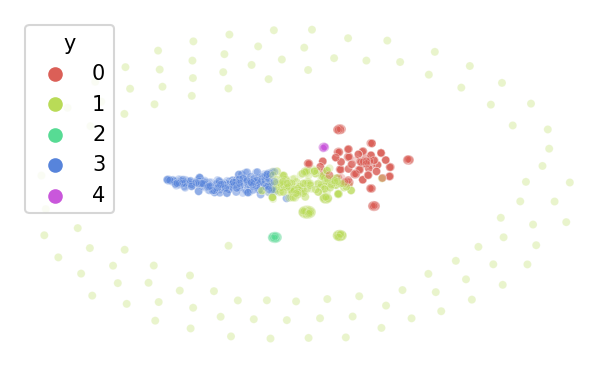

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

df_subset = pd.DataFrame()
df_subset['tsne-one'] = tsne_results[:,0]
df_subset['tsne-two'] = tsne_results[:,1] 
df_subset['y'] = assigned_clusters

fig = plt.figure(figsize=(5,3), dpi = 150)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

sc = sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="y",
    palette=sns.color_palette("hls", len(centroids)),
    data=df_subset,
    alpha=0.3,
    s=15
)

In [27]:
df_subset["y"]

0       3
1       1
2       0
3       1
4       0
       ..
1105    3
1106    3
1107    1
1108    3
1109    3
Name: y, Length: 1110, dtype: int32

Vediamo che si sono dei raggruppamenti. La maggior parte delle istanze cade nel raggruppamento centrale. Il raggruppamento grande che circonda tutto viene considerato come un unico cluster.

Andiamo ora a rappresentare i word-cloud

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=500, 
                      height=200, 
                      prefer_horizontal=0.5,
                      background_color="white", mode="RGBA")

def cloud(data): #funzione che prende i dati e produce la word-cloud
    wordcloud.fit_words(data)
    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


CLUSTER 0, len: 310


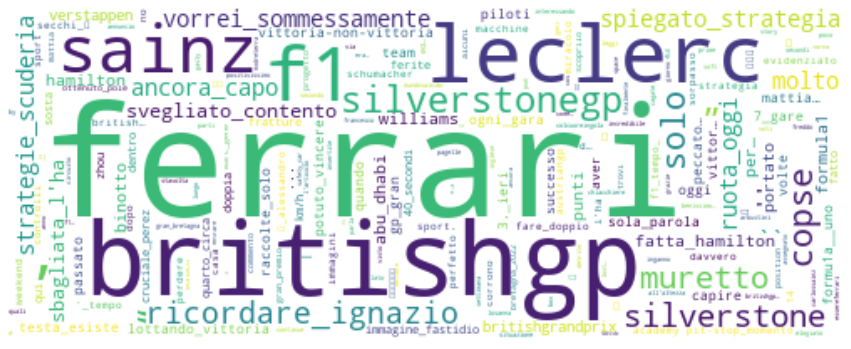

CLUSTER 1, len: 441


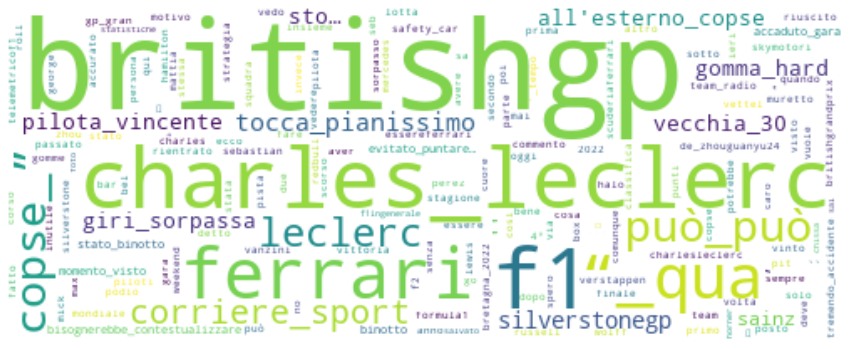

CLUSTER 2, len: 28


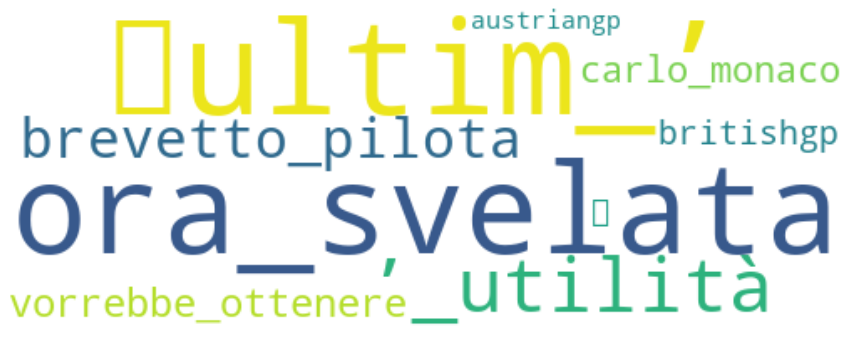

CLUSTER 3, len: 318


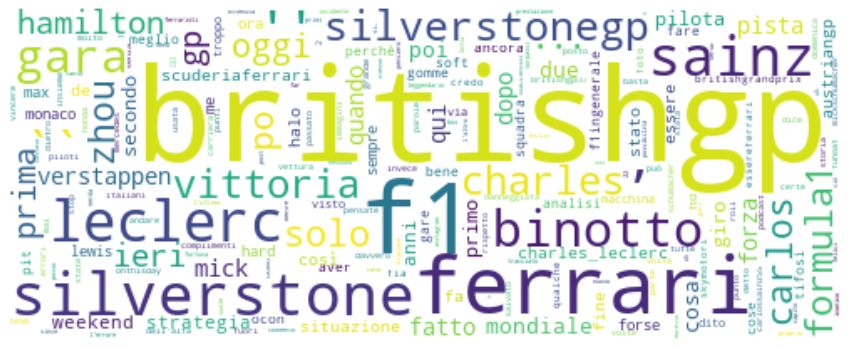

CLUSTER 4, len: 13


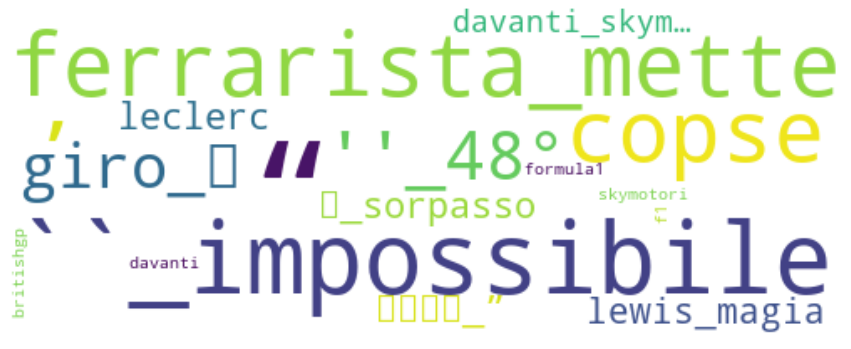

In [29]:
sentences = np.array(sentences)

for cluster in range(NUM_CLUSTERS): # per ogni cluster prendo le frasi associate e prendo le parole
    cluster_sentences = sentences[assigned_clusters == cluster]
    words = pd.Series([item for sublist in cluster_sentences for item in sublist]) #esplosione di tutte le parole in un cluster
    print("CLUSTER {}, len: {}".format(cluster, len(cluster_sentences))) 
    cloud(words.value_counts()) 

veidmao i diversi cluster creati. Per ogni cluster leggiamo il numero e il numero di embedding che ne fanno parte. 

Cluster 1 ha 87 embeddings ma risulta formato di poche parole: dovuto al fatto che ci sia un tweet particolarmente retweettato. Andando a vedere il grafico 2d ci accorgiamo che il cluster 1 è wuello che circonda tutti gli altri. Si tratta di retweet simili ma diversi dalle altre istanze del dataset. 

cluster 0 è il cluster centrale ed è particolarmente pieno di parole. Contiene la maggior parte delle istanze relative alla guerra 




### Calcolo numero cluster ottimale
Metodo del Gomito: cerchiamo di capire quale risulta essere il numero di cluster migliore da poter scegliere. 

DObbiamo effettuare il clustering piu volte per calcolare l'inerzia e scegliere il numero di cluster migliore. 

In [30]:
wcss = []

for i in range(1,20):
    kmeans = KMeans(n_clusters=i) # ad ogni iterazione eseguo clustering con un numero diverso di cluster
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

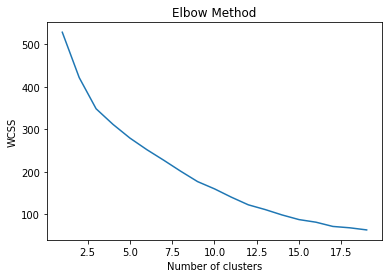

In [31]:
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Osserviamo che non esiste un punto chiaro (gomito) in cui la discesa cambia nettamente. Puo essere comunque ottimale scegliere un numero di cluster tra 7 e 10

Per ottenere un risultato migliore dell'algoritmo di clustering puo essere ottimale scegliere opportuni parametri di configurazione del Kmeans. 

Ricordiamo che Kmeans parte da centroidi scelti a caso e la scelta iniziale potrebbe non essere ottimale per arrivare al risultato finale.



#Parte 8: Transfer learning 

vado a considerare un modello addestrato su molti piu dati di quelli che avrei potuto utilizzare io (pre-addestrato)

In [32]:
# https://mlunicampania.gitlab.io/italian-word2vec/

from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load("/content/drive/MyDrive/Colab Notebooks/W2V.kv", mmap='r+') 
vocabs = word_vectors.index2word
vectors = word_vectors.vectors

2022-07-10 15:53:32,694 : INFO : loading Word2VecKeyedVectors object from /content/drive/MyDrive/Colab Notebooks/W2V.kv
2022-07-10 15:53:34,815 : INFO : loading vectors from /content/drive/MyDrive/Colab Notebooks/W2V.kv.vectors.npy with mmap=r+
2022-07-10 15:53:35,368 : INFO : setting ignored attribute vectors_norm to None
2022-07-10 15:53:35,371 : INFO : loaded /content/drive/MyDrive/Colab Notebooks/W2V.kv


In [33]:
embeddings = []
for sentence in sentences:
    sentence_embedding = np.zeros((300,)) #preaddestrato su una dimensione di 300 quindi mi devo adattare a questa dimensione dell'array
    for word in sentence:
        try:
            sentence_embedding += word_vectors[word]
        except:
            pass
    sentence_embedding = sentence_embedding/len(sentence)
    embeddings.append(sentence_embedding)

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, n_iter=300, verbose=1) #settati altri iperparametri
tsne_results = tsne.fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1110 samples in 0.000s...
[t-SNE] Computed neighbors for 1110 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1110
[t-SNE] Computed conditional probabilities for sample 1110 / 1110
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.884399
[t-SNE] KL divergence after 300 iterations: 0.955159


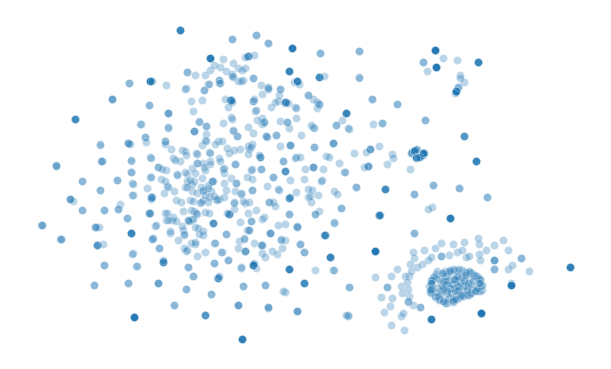

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

df_subset = pd.DataFrame()
df_subset['tsne-one'] = tsne_results[:,0]
df_subset['tsne-two'] = tsne_results[:,1] 

fig = plt.figure(figsize=(5, 3), dpi = 150)

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

sc = sns.scatterplot(
    x="tsne-one", y="tsne-two",
    data=df_subset,
    legend=None,
    alpha=0.3,
    s=15
)

Gli embedding ricavati con questo metodo gia vedo che sono molto diversi rispetto a quelli ricavati in precedenza. 

In [36]:
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)

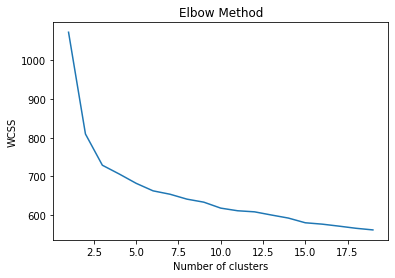

<Figure size 432x288 with 0 Axes>

In [44]:
plt.plot(range(1, 20), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/Elbow_method.jpg')

Cluster 0: 📰la forza vivere passato ferrari 2007 ricominciare presente 🔗 scritto da🖊️ milly_sunshine f1 britishgp massa raikkonen ferrari sainz leclerc 🏁
Cluster 1: 🏎 ferrari pessima strategia gomme costa caro “ intenso ” così potrebbe essere definito weekend britishgp ’ solo cosa sembra diventando costante ferrari ancora volta buttato via punti 🖋 stefaniademasii f1
Cluster 2: 🚨ultim_’ ora_svelata ’_utilità brevetto_pilota vorrebbe_ottenere carlo_monaco 🚨 britishgp austriangp
CLUSTER 0, len: 280


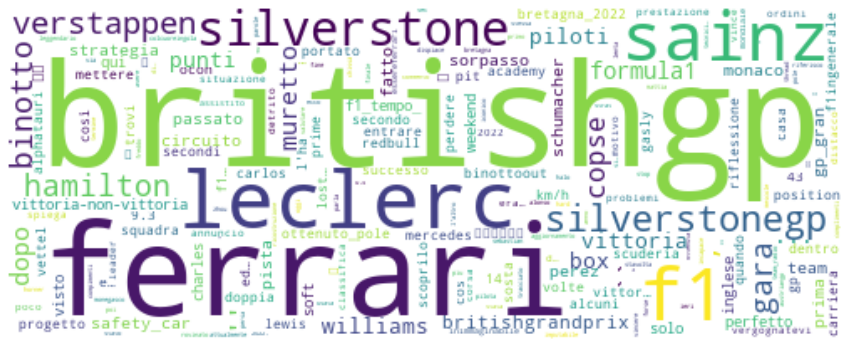

CLUSTER 1, len: 482


<Figure size 432x288 with 0 Axes>

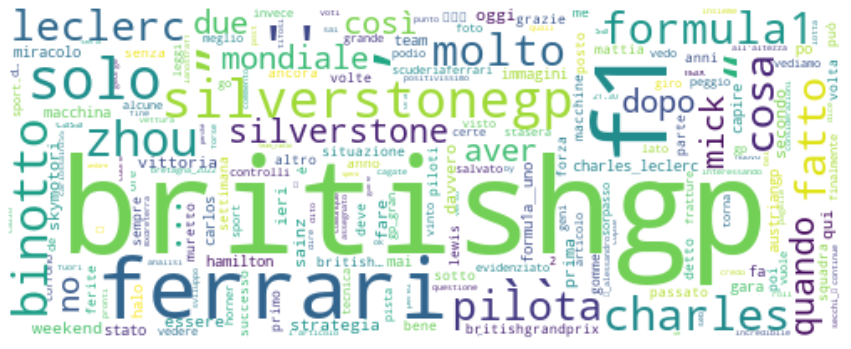

CLUSTER 2, len: 348


<Figure size 432x288 with 0 Axes>

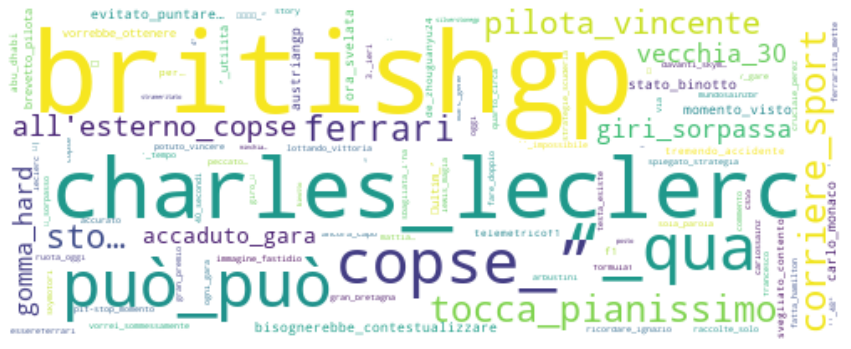

<Figure size 432x288 with 0 Axes>

In [42]:
from sklearn.cluster import KMeans
import nltk

NUM_CLUSTERS = 3

kclusterer = KMeans(NUM_CLUSTERS)
assigned_clusters = kclusterer.fit(embeddings)

centroids  = kclusterer.cluster_centers_

from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(centroids, embeddings)

for i, id in enumerate(closest):
    print("Cluster {}: {}".format(i,' '.join(sentences[id])))

assigned_clusters = assigned_clusters.labels_

for cluster in range(NUM_CLUSTERS):
    cluster_sentences = sentences[assigned_clusters == cluster]
    words = pd.Series([item for sublist in cluster_sentences for item in sublist])
    print("CLUSTER {}, len: {}".format(cluster, len(cluster_sentences)))
    cloud(words.value_counts())



In [ ]:
df.head()

In [40]:
df["clusters"] = assigned_clusters  

In [ ]:
df.tail()

In [84]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/BritishGP_cleaned_clusters_1000.csv", index=False)